In [17]:
import os
import glob
import math
import warnings

import numpy as onp
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

import pennylane as qml
from pennylane import numpy as np

warnings.filterwarnings("ignore", category=UserWarning, module="pennylane.math.utils")


In [18]:
def load_jets_from_npz(folder_path):
    """
    Loads jet data from all .npz files in the given folder.
    Returns the particle features (X) and jet labels (y).
    """
    all_files = sorted(glob.glob(f"{folder_path}/*.npz"))
    print(len(all_files))
    X, y = [], []
    
    for file in all_files:
        data = np.load(file)
        X = (data["X"])  # Particle features
        y = (data["y"])  # Jet labels

        X = np.concatenate((X, data["X"]), axis=0)
        y = np.concatenate((y, data["y"]), axis=0)

    return X, y

X, y = load_jets_from_npz("data/")

1


In [19]:
list_jets = []
for i in range(len(X)):
    particles = X[i]
    particles = particles[particles[:, 0] != 0]  # Remove padding
    df = pd.DataFrame(particles, columns=["pT", "Rapidity", "Azimuth", "pdgid"])
    list_jets.append(df)

The whole pipeline consists in taking a collection of particles in a jet, identifying the most important ones based on their energy and proximity, and then building a graph that represents how these key particles are related to each other in terms of their location. This graph representation captures the structure of the jet in a way that can then be encoded into the quantum circuit.

In [20]:
def build_jet_graph(jet_df, n_neighbors=10, edge_neighbors=3):

    hardest_index = jet_df['pT'].idxmax()
    hardest_particle = jet_df.loc[hardest_index]

    coords = jet_df[['Rapidity', 'Azimuth']].values
    H_coord = hardest_particle[['Rapidity', 'Azimuth']].values.reshape(1, -1)
    
    nbrs = NearestNeighbors(n_neighbors=min(n_neighbors, len(jet_df)), algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(H_coord)
    selected_indices = indices[0]
    
    selected_nodes = jet_df.iloc[selected_indices].copy()
    
    if hardest_index not in selected_nodes.index:
        selected_nodes = pd.concat([pd.DataFrame([hardest_particle]), selected_nodes])
        selected_nodes = selected_nodes.drop_duplicates()

    selected_nodes = selected_nodes.reset_index(drop=True)

    selected_coords = selected_nodes[['Rapidity', 'Azimuth']].values
    nbrs_selected = NearestNeighbors(n_neighbors=min(edge_neighbors + 1, len(selected_nodes)), 
                                       algorithm='ball_tree').fit(selected_coords)
    distances_edges, indices_edges = nbrs_selected.kneighbors(selected_coords)

    G = nx.Graph()
    for i, row in selected_nodes.iterrows():
        G.add_node(i, log_pT=np.log(row['pT']))

    for i, neighbors in enumerate(indices_edges):
        for j in neighbors[1:]:
            if not G.has_edge(i, j):
                G.add_edge(i, j)
    
    return G


graph_list = []
for jet_df in tqdm(list_jets[:1000], desc="Building graphs"):
    G = build_jet_graph(jet_df, n_neighbors=10, edge_neighbors=3)
    graph_list.append(G)

Building graphs: 100%|██████████| 1000/1000 [00:01<00:00, 688.60it/s]


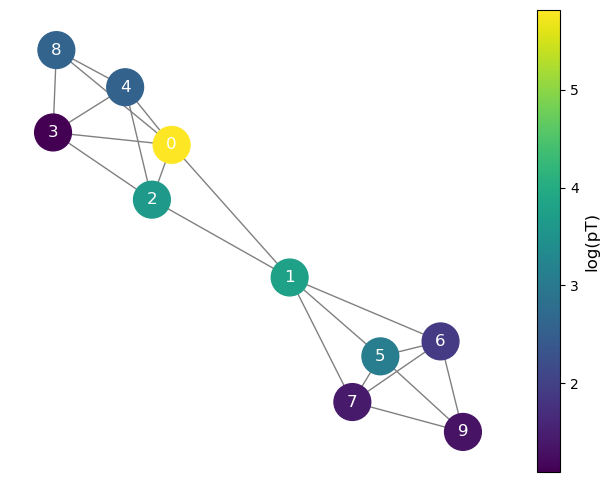

In [21]:
graph = graph_list[0]  # Example: visualize the first graph
node_values = [graph.nodes[node].get('log_pT', 0) for node in graph.nodes()]
pos = nx.spring_layout(graph, seed=42)

plt.figure(figsize=(8, 6))
nodes = nx.draw_networkx_nodes(
    graph, pos,
    node_color=node_values,
    cmap=plt.cm.viridis,
    node_size=700
)

nx.draw_networkx_edges(graph, pos, edge_color='gray')
nx.draw_networkx_labels(graph, pos, font_size=12, font_color='white')
cbar = plt.colorbar(nodes)
cbar.set_label("log(pT)", fontsize=12)
plt.axis("off")
plt.show()


# Quantum Graph Neural Network (QGNN) Circuit

This circuit is designed to process graph-structured data using quantum operations. It maps key node features from a graph (specifically, the logarithm of the transverse momentum, `log_pT`) into a quantum state and processes the graph structure through entanglement and parameterized rotations. Below is an outline of the circuit:

1. **Node Encoding:**  
   - Each node's feature (`log_pT`) is encoded into the corresponding qubit using an `RY` rotation.
   - The rotation angle is given by `log_pT * π`, ensuring the feature influences the quantum state.

2. **First Entanglement Layer:**  
   - Entangling operations are performed using CNOT gates.
   - The CNOTs are applied between qubits according to the graph’s edge connections, reflecting the structural relationships among nodes.

3. **Quantum Neuron Layer:**  
   - Each qubit undergoes a set of parameterized rotations: `RX`, `RY`, and `RZ`.
   - These rotations act as learnable parameters, analogous to weights in a classical neural network, allowing the circuit to transform the encoded features.

4. **Second Entanglement Layer:**  
   - A second set of CNOT gates is applied with the same connectivity as the first entanglement layer.
   - This further mixes the quantum information and reinforces the graph structure within the quantum state.

5. **Measurement:**  
   - The circuit measures each qubit using the PauliZ operator.
   - The output is a list of expectation values (one per node) that represent the processed features of the graph.

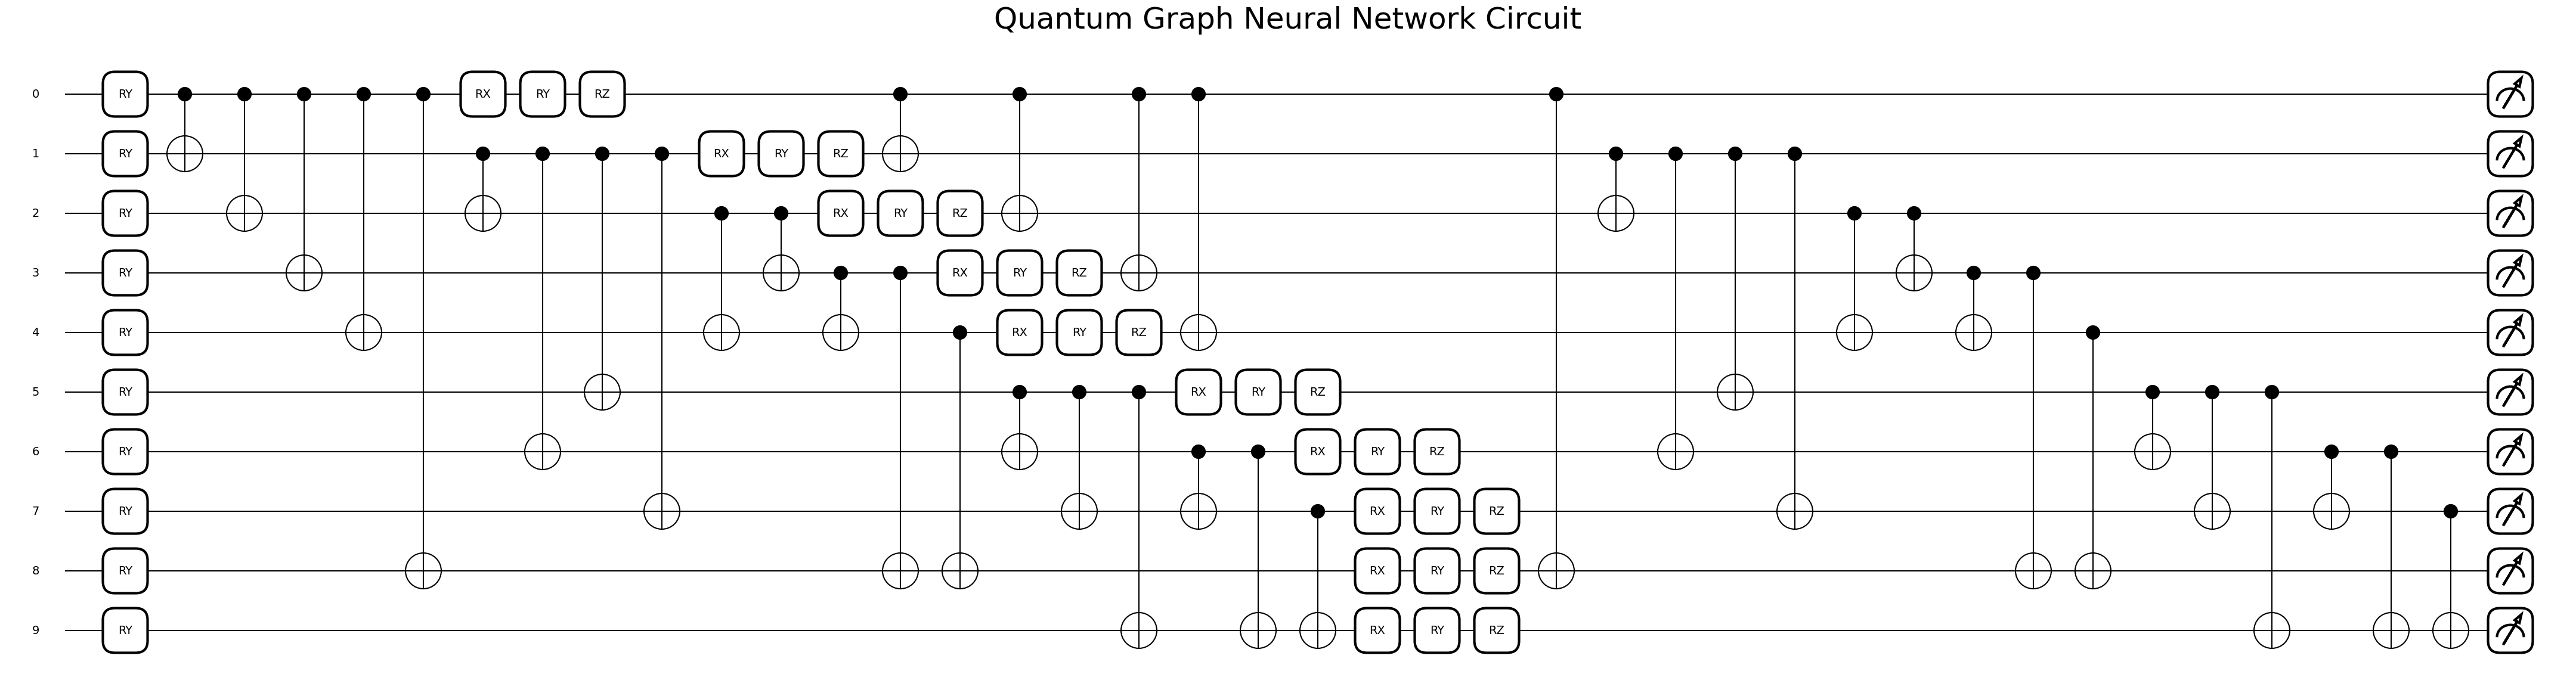

Individual qubit measurements: [tensor(0.13297979, requires_grad=True), tensor(-0.09382069, requires_grad=True), tensor(-0.0681076, requires_grad=True), tensor(0.00884231, requires_grad=True), tensor(0.03071611, requires_grad=True), tensor(-0.03735425, requires_grad=True), tensor(0.18558904, requires_grad=True), tensor(-0.61713526, requires_grad=True), tensor(0.03222497, requires_grad=True), tensor(0.00463576, requires_grad=True)]
Mean measurement (pooled output): -0.042142982670328524


In [22]:
num_nodes = 10
graph = graph_list[0]

dev = qml.device("default.qubit", wires=num_nodes)

@qml.qnode(dev)
def qgnn_circuit(graph, params):

    nodes_data = sorted(graph.nodes(data=True), key=lambda x: x[0])
    num_nodes = len(nodes_data)
    
    features = np.array([attr.get("log_pT", 0) for _, attr in nodes_data]).reshape(-1, 1)
    edges = list(graph.edges())
    
    for i in range(num_nodes):
        qml.RY(features[i, 0] * np.pi, wires=i)
    
    for i, j in edges:
        qml.CNOT(wires=[i, j])
    
    for i in range(num_nodes):
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i, 1], wires=i)
        qml.RZ(params[i, 2], wires=i)
    
    for i, j in edges:
        qml.CNOT(wires=[i, j])
    
    return [qml.expval(qml.PauliZ(i)) for i in range(num_nodes)]

# Each node gets 3 rotation parameters (RX, RY, RZ).
params = np.random.rand(num_nodes, 3) * 2 * np.pi

circuit_diagram = qml.draw_mpl(qgnn_circuit)(graph, params)
plt.title("Quantum Graph Neural Network Circuit", fontsize=36)
plt.show()

exp_vals = qgnn_circuit(graph, params)

exp_vals_tensor = qml.math.stack(exp_vals)
mean_measurement = qml.math.mean(exp_vals_tensor)

print("Individual qubit measurements:", exp_vals)
print("Mean measurement (pooled output):", mean_measurement)

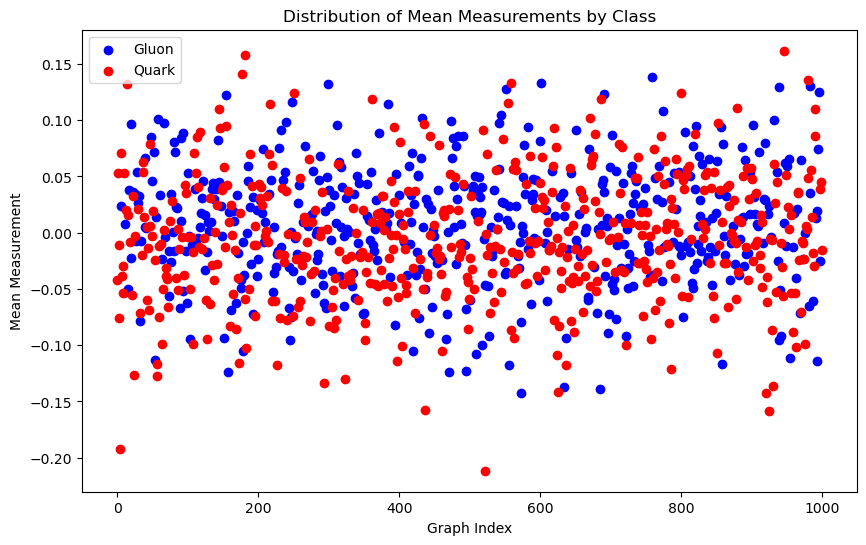

In [23]:
indices_gluon = []
measurements_gluon = []
indices_quark = []
measurements_quark = []

for i, graph in enumerate(graph_list):
    exp_vals = qgnn_circuit(graph, params)
    exp_vals_tensor = qml.math.stack(exp_vals)
    mean_measurement = qml.math.mean(exp_vals_tensor)
    
    if y[i] == 0:
        indices_gluon.append(i)
        measurements_gluon.append(mean_measurement)
    else:
        indices_quark.append(i)
        measurements_quark.append(mean_measurement)

plt.figure(figsize=(10, 6))
plt.scatter(indices_gluon, measurements_gluon, color='blue', label='Gluon')
plt.scatter(indices_quark, measurements_quark, color='red', label='Quark')
plt.xlabel("Graph Index")
plt.ylabel("Mean Measurement")
plt.title("Distribution of Mean Measurements by Class")
plt.legend()
plt.show()

From the plot, it is evident that there is no clear distinction between Gluon and Quark jets after processing them through the quantum circuit. This result is not entirely surprising for two reasons:

- **Limited Input Data:** Only 10 particles per jet are used, which may not sufficiently capture the complex structure of the jet.
- **Untrained Parameters:** The quantum circuit’s parameters have not undergone any training, meaning the circuit operates with random initialization rather than optimized weights.

Despite these limitations, the circuit's architecture is valid, and with proper training, it is capable of learning discriminative features from the jet data. Future work should focus on increasing the number of particles and optimizing the circuit parameters to improve classification performance.
